In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import time
matfile = sio.loadmat('data_mac1_cleaned.mat')
data = matfile['data']

print(data.dtype.names)
print(data.shape)
# format: data['variable name'] [0] [sample index] [0] [time step]
# e.g.: print(data['bus_v']     [0]     [432]      [0]   [124])

('bus_v', 'cur', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect', 'length', 'filename')
(1, 5277)


In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name, end='')
        print('Elapsed: %.2fs' % (time.time() - self.tstart))

In [3]:
# Data pre-processing
np.random.seed(20200412)
n_sample = 1500
use_mac_ang = True
use_Polar = True
use_cur_sum = True


# sample_idx = np.random.permutation(5864)
sample_idx = np.random.permutation(5277)
# sample_idx = np.arange(5864)

# Train data set size: (4379554, 18)
# Test data set size: (759128, 18)

if use_cur_sum:
    train_data = np.zeros((6000000, 10), dtype=np.float32)
else:
    train_data = np.zeros((6000000, 18), dtype=np.float32)
# train_label_raw = np.zeros((1313141, 8), dtype=np.float32)
# train_data = np.zeros((4381585, 18), dtype=np.float32)
# train_label_raw = np.zeros((4381585, 8), dtype=np.float32)
# train_data = np.zeros((6000000, 18), dtype=np.float32)
train_label_raw = np.zeros((6000000, 8), dtype=np.float32)
n_entry = 0
with Timer('Import train data'):
    for i in sample_idx[:n_sample]:
        bus_v = data['bus_v'][0][i].reshape(-1, 1)
        cur = data['cur'][0][i].reshape(-1, 1)
        bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
        mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
        mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
        pelect = data['pelect'][0][i].reshape(-1, 1)
        pmech = data['pmech'][0][i].reshape(-1, 1)
        qelect = data['qelect'][0][i].reshape(-1, 1)
        length = qelect.shape[0]

        if not use_mac_ang:
            mac_ang = np.zeros_like(mac_ang)

#         if use_cur_sum:
#             cur = np.sum(cur, axis=1).reshape(-1, 1)


        bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
        cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
        tmp_train_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
        tmp_train_label = np.delete(tmp_train_data, 0, 0)  # delete the first sample(shift the curve left)

        # delete the currents(we don't need to predict that)
        if use_cur_sum:
            tmp_train_label = np.delete(tmp_train_label, np.arange(2, 4), 1)
        else:
            tmp_train_label = np.delete(tmp_train_label, np.arange(2, 12), 1)
        tmp_train_data = np.delete(tmp_train_data, -1, 0)  # delete the last sample because there's no corresponding label

        length = tmp_train_data.shape[0]
        train_data[n_entry:n_entry + length, :] = tmp_train_data
        train_label_raw[n_entry:n_entry + length, :] = tmp_train_label

        n_entry += length
    del tmp_train_data
    del tmp_train_label

train_data = train_data[:n_entry, :].copy()
train_label_raw = train_label_raw[:n_entry, :].copy()

if use_cur_sum:
    test_data = np.zeros((2000000, 10), dtype=np.float32)
else:
    test_data = np.zeros((2000000, 18), dtype=np.float32)
# test_label_raw = np.zeros((757097, 8), dtype=np.float32)
# test_data = np.zeros((2000000, 18), dtype=np.float32)
test_label_raw = np.zeros((2000000, 8), dtype=np.float32)

n_entry = 0
with Timer('Import test data'):
    for i in sample_idx[4500:]:
        bus_v = data['bus_v'][0][i].reshape(-1, 1)
        cur = data['cur'][0][i].reshape(-1, 1)
        bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
        mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
        mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
        pelect = data['pelect'][0][i].reshape(-1, 1)
        pmech = data['pmech'][0][i].reshape(-1, 1)
        qelect = data['qelect'][0][i].reshape(-1, 1)
        length = qelect.shape[0]

        if not use_mac_ang:
            mac_ang = np.zeros_like(mac_ang)

#         if use_cur_sum:
#             cur = np.sum(cur, axis=1).reshape(-1, 1)

        bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
        cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
        tmp_test_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
        tmp_test_label = np.delete(tmp_test_data, 0, 0)  # delete the first sample(shift the curve left)
        if use_cur_sum:
            tmp_test_label = np.delete(tmp_test_label, np.arange(2, 4), 1)
        else:
            tmp_test_label = np.delete(tmp_test_label, np.arange(2, 12), 1)
        tmp_test_data = np.delete(tmp_test_data, -1, 0)  # delete the last sample because there's no corresponding label
        length = tmp_test_data.shape[0]
        test_data[n_entry:n_entry + length, :] = tmp_test_data
        test_label_raw[n_entry:n_entry + length, :] = tmp_test_label

        n_entry += length
    del tmp_test_data
    del tmp_test_label

test_data = test_data[:n_entry, :].copy()
test_label_raw = test_label_raw[:n_entry, :].copy()

# train_label_raw[:, :2] = train_data[:, :2]
# test_label_raw[:, :2] = test_data[:, :2]

if use_cur_sum:
    train_label = train_label_raw - train_data[:, [0, 1, 4, 5, 6, 7, 8, 9]]
    test_label = test_label_raw - test_data[:, [0, 1, 4, 5, 6, 7, 8, 9]]
else:
    train_label = train_label_raw - train_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]
    test_label = test_label_raw - test_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]

# train_label[:, 1] = np.mod(train_label[:, 1]+np.pi, 2*np.pi) - np.pi
# test_label[:, 1] = np.mod(test_label[:, 1]+np.pi, 2*np.pi) - np.pi

# train_label[:, :3] = 0
# test_label[:, :3] = 0

label_mean = np.mean(train_label, axis=0)
label_std = np.std(train_label, axis=0)
label_std[np.less(label_std, 1e-7)] = 1e-7
# label_mean[1] = 0  # remove normalization on angle of bus_v
# label_std[1] = 1
train_label = (train_label - label_mean) / label_std
test_label = (test_label - label_mean) / label_std

print(label_std)

norm_mean = np.mean(train_data, axis=0)
norm_std = np.std(train_data, axis=0)
norm_std[np.less(norm_std, 1e-7)] = 1e-7
train_data = (train_data - norm_mean) / norm_std
test_data = (test_data - norm_mean) / norm_std

print('Train data set size:', train_data.shape)
print('Test data set size:', test_data.shape)

[Import train data]Elapsed: 0.62s
[Import test data]Elapsed: 0.32s
[2.2701372e-03 2.2055718e-01 5.9581450e-03 2.5542459e-01 1.4501832e-04
 2.8157923e-02 1.0000000e-07 2.2688560e-02]
Train data set size: (1334227, 10)
Test data set size: (691127, 10)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        feature_dimension = 128
        self.n_residual_block = 3
        
        self.prelayer = nn.Linear(10, feature_dimension)
        
        self.residual_block = nn.ModuleList()
        for i in range(self.n_residual_block):
            block = nn.Sequential(
                nn.Linear(feature_dimension, feature_dimension),
#                 nn.BatchNorm1d(feature_dimension),
#                 nn.ReLU(inplace=True),
                nn.Tanh(),

                nn.Linear(feature_dimension, feature_dimension),
#                 nn.BatchNorm1d(feature_dimension)
#             nn.ReLU(inplace=True)
            )
            self.residual_block.append(block)

#         self.network = nn.Sequential(
#                 nn.ReLU(inplace=True),
            
#                 nn.Linear(feature_dimension, feature_dimension),
#                 nn.ReLU(inplace=True),
#             )
        
        self.output_layer = nn.Linear(feature_dimension, 8)


    def forward(self, x):
        x = self.prelayer(x)
        
#         x = self.network(x)
        
        for residual_block in self.residual_block:
            x1 = residual_block(x)
            x = F.relu(x + x1, inplace=True)
        
        x = self.output_layer(x)
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        #         torch.nn.init.kaiming_normal_(m.weight)
#         torch.nn.init.normal_(m.weight, mean=0, std=0.001)
        torch.nn.init.normal_(m.bias, mean=0, std=0.001)
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(m.bias, mode='fan_in', nonlinearity='relu')

    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.zeros_(m.bias)
        torch.nn.init.ones_(m.weight)


model = NN().float()
use_GPU = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(20200410)
if torch.cuda.is_available():
    print('GPU is available. Will be applied.')
    use_GPU = True
    model = model.cuda()

    torch.cuda.empty_cache()
    torch.cuda.manual_seed(20200410)
    torch.cuda.manual_seed_all(20200410)
    torch.backends.cudnn.deterministic = True

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

print('This model has {:d} layers and {:d} trainable parameters. '.format(model.n_residual_block*2+2, get_n_params(model)))
    
model.apply(weights_init)

batchsize = 150000
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01*2, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters())

train_data_torch = torch.from_numpy(train_data).float()
train_label_torch = torch.from_numpy(train_label).float()
test_data_torch = torch.from_numpy(test_data).float()
test_label_torch = torch.from_numpy(test_label).float()

loss_curve = []

# f0 = plt.figure(0, figsize=(15,5))
# ax0 = f0.gca()
# ax0.plot([0])
# f0.canvas.draw()


def test(data_torch, label_torch):
    loss = None
    prediction = None
    model.eval()
    for j in range(0, data_torch.shape[0], batchsize):
        inputs_torch = data_torch[j:j+batchsize, :]
        labels_torch = label_torch[j:j+batchsize, :]

        if use_GPU:
            inputs_torch = inputs_torch.cuda()
            labels_torch = labels_torch.cuda()
#         print(inputs_torch.device, labels_torch.device)
        # forward
        pred_torch = model(inputs_torch)
        loss_torch = criterion(pred_torch, labels_torch)

        if use_GPU:
            pred_torch = pred_torch.cpu()
        pred = pred_torch.data.numpy()

        loss = np.array([loss_torch.item()]) if loss is None else np.hstack([loss, loss_torch.item()])
        prediction = pred if prediction is None else np.vstack([prediction, pred])
    return loss.mean(), prediction


loss, _ = test(train_data_torch, train_label_torch)
loss_test, _ = test(test_data_torch, test_label_torch)
print('Before training: train Loss = %.3e, test Loss = %.3e' % (loss, loss_test))
epochs_ = 1

GPU is available. Will be applied.
This model has 8 layers and 101512 trainable parameters. 
Before training: train Loss = 8.083e+00, test Loss = 7.541e+00


14:56:33  Epoch 50: train Loss = 1.538e-01, test Loss = 1.485e-01
14:57:12  Epoch 100: train Loss = 1.377e-01, test Loss = 1.342e-01
14:57:52  Epoch 150: train Loss = 1.414e-01, test Loss = 1.356e-01
14:58:32  Epoch 200: train Loss = 1.289e-01, test Loss = 1.283e-01
14:59:11  Epoch 250: train Loss = 1.256e-01, test Loss = 1.252e-01
14:59:51  Epoch 300: train Loss = 1.292e-01, test Loss = 1.307e-01
15:00:31  Epoch 350: train Loss = 1.270e-01, test Loss = 1.270e-01
15:01:11  Epoch 400: train Loss = 1.185e-01, test Loss = 1.233e-01
15:01:51  Epoch 450: train Loss = 1.336e-01, test Loss = 1.359e-01
15:02:30  Epoch 500: train Loss = 1.152e-01, test Loss = 1.208e-01
15:03:10  Epoch 550: train Loss = 1.328e-01, test Loss = 1.337e-01
15:03:50  Epoch 600: train Loss = 1.250e-01, test Loss = 1.279e-01
15:04:30  Epoch 650: train Loss = 1.175e-01, test Loss = 1.238e-01
15:05:10  Epoch 700: train Loss = 1.104e-01, test Loss = 1.183e-01
15:05:50  Epoch 750: train Loss = 1.034e-01, test Loss = 1.094e

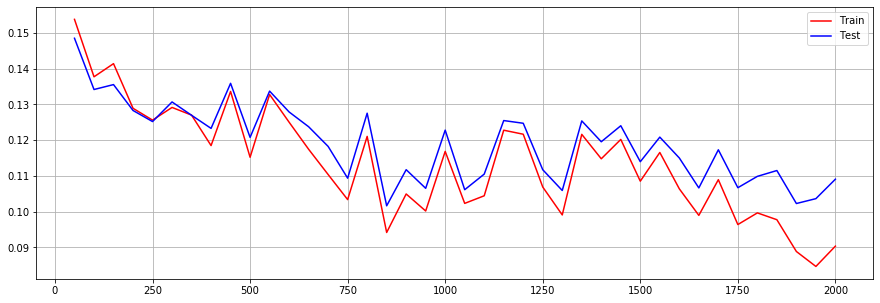

GPU memory stats: Max Cached 1206 Mb, Max Reserved 1206 Mb, Max Allocated 1155 Mb
Denormalized: train Loss = 8.656e-05, test Loss = 1.220e-04
mac_spd: train Loss = 2.855e-11, test Loss = 3.571e-11


In [5]:
%matplotlib inline
model.cuda()

for i in range(epochs_, epochs_+2000):
    model.train()
    for j in range(0, train_data.shape[0], batchsize):
        inputs = train_data_torch[j:j+batchsize, :].cuda()
        labels = train_label_torch[j:j+batchsize, :].cuda()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 50 == 0:
        loss, _ = test(train_data_torch, train_label_torch)
        loss_test, _ = test(test_data_torch, test_label_torch)

        loss_curve.append([i, loss, loss_test])

    if i % 50 == 0:
        print(time.strftime('%H:%M:%S  ', time.localtime(time.time())), end="")
        print('Epoch {}: train Loss = {:.3e}, test Loss = {:.3e}'.format(i, loss, loss_test))

plt.figure(0, figsize=(15, 5))
plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 1], 'r', label="Train")
plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 2], 'b', label="Test")
plt.grid(True)
plt.legend()
plt.show()

print('GPU memory stats: Max Cached {:.0f} Mb, Max Reserved {:.0f} Mb, Max Allocated {:.0f} Mb'.format(
    torch.cuda.max_memory_cached(0)/1024/1024, torch.cuda.max_memory_reserved(0)/1024/1024, torch.cuda.max_memory_allocated(0)/1024/1024))

_, prediction_train_raw = test(train_data_torch, train_label_torch)
_, prediction_test_raw = test(test_data_torch, test_label_torch)

if use_cur_sum:
    prediction_train = prediction_train_raw * label_std + label_mean + (train_data * norm_std + norm_mean)[:, [0, 1, 4, 5, 6, 7, 8, 9]]
    prediction_test = prediction_test_raw * label_std + label_mean + (test_data * norm_std + norm_mean)[:, [0, 1, 4, 5, 6, 7, 8, 9]]
else:
    prediction_train = prediction_train_raw * label_std + label_mean + (train_data * norm_std + norm_mean)[:, [0, 1, 12, 13, 14, 15, 16, 17]]
    prediction_test = prediction_test_raw * label_std + label_mean + (test_data * norm_std + norm_mean)[:, [0, 1, 12, 13, 14, 15, 16, 17]]

mse_train = np.mean(np.square(prediction_train - train_label_raw), axis=0)
mse_test = np.mean(np.square(prediction_test - test_label_raw), axis=0)

print('Denormalized: train Loss = %.3e, test Loss = %.3e' % (mse_train.mean(), mse_test.mean()))
print('mac_spd: train Loss = %.3e, test Loss = %.3e' % (mse_train[4], mse_test[4]))

3.98e-08,4.62e-04,2.44e-05,1.96e-04,2.85e-11,5.80e-06,2.66e-21,4.51e-06
2.29e-07,6.74e-04,2.81e-05,2.23e-04,3.57e-11,1.22e-05,0.00e+00,3.87e-05


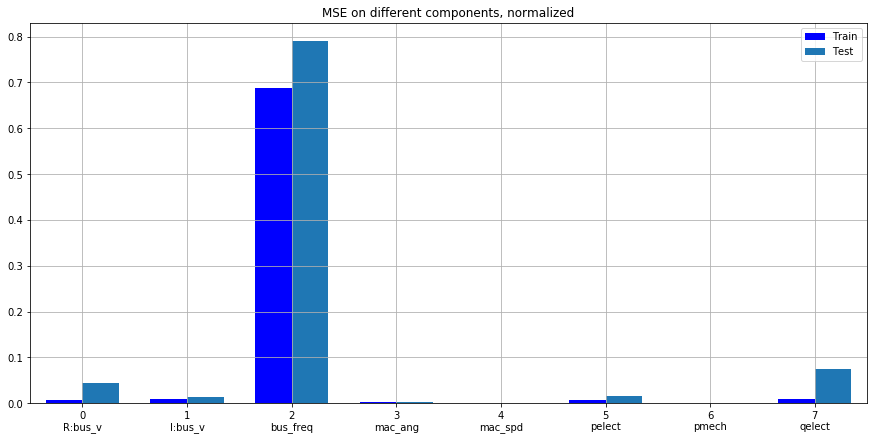

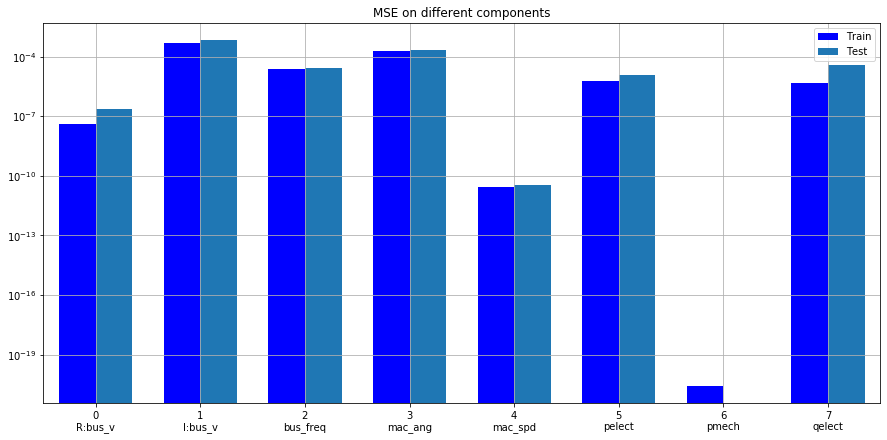

In [6]:
c = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange', 'b', 'b', 'b']
c2 = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'darkorange', 'C0', 'C0', 'C0']
x = np.arange(8)
# xticks=('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect')
xticks = ('0\nR:bus_v', '1\nI:bus_v', '2\nbus_freq', '3\nmac_ang', '4\nmac_spd', '5\npelect', '6\npmech', '7\nqelect')
width = 0.35

# plt.figure(1,figsize=(15,7))
# plt.bar(range(8), norm_std, color=c)
# plt.xticks(range(8), ('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect'))
# plt.grid(True)
# plt.xlim([-0.5,17.5])
# # plt.ylim([0,0.001])
# plt.title('Standard Deviations on different components')

mse_train_n = np.mean(np.square(prediction_train_raw - train_label), axis=0)
mse_test_n = np.mean(np.square(prediction_test_raw - test_label), axis=0)

plt.figure(2, figsize=(15, 7))
plt.bar(x-width/2, mse_train_n, width, label='Train', color=c)
plt.bar(x+width/2, mse_test_n, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
# plt.ylim([0,1e-6])
plt.title('MSE on different components, normalized')


plt.figure(3, figsize=(15, 7))
plt.bar(x-width/2, mse_train, width, label='Train', color=c)
plt.bar(x+width/2, mse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
plt.yscale('log')
# plt.ylim([0,1e-1])
plt.title('MSE on different components')
print('{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e}'.format(mse_train[0], mse_train[1], mse_train[2], mse_train[3], mse_train[4], mse_train[5], mse_train[6], mse_train[7]))
print('{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e},{:.2e}'.format(mse_test[0], mse_test[1], mse_test[2], mse_test[3], mse_test[4], mse_test[5], mse_test[6], mse_test[7]))

plt.show()

(890, 1) (890, 1) (890, 1) (890, 1)


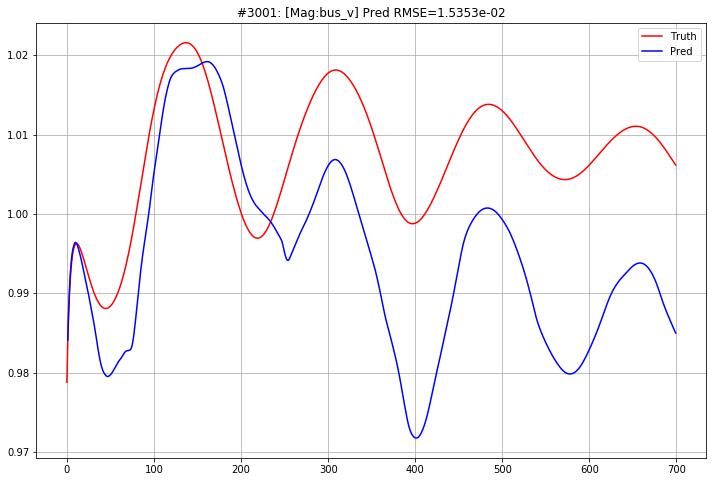

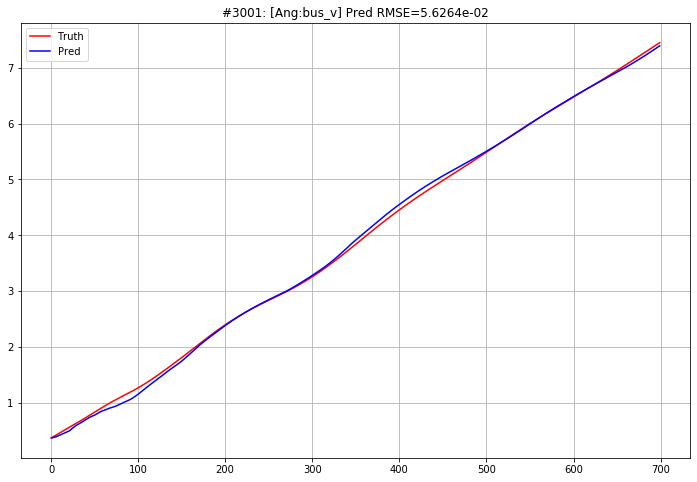

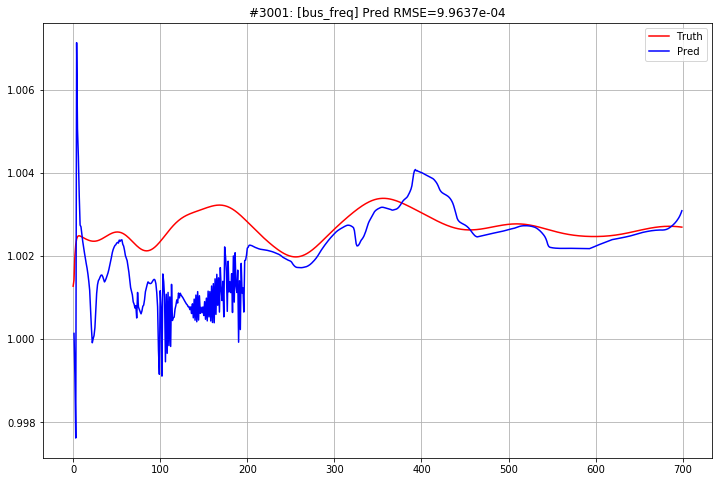

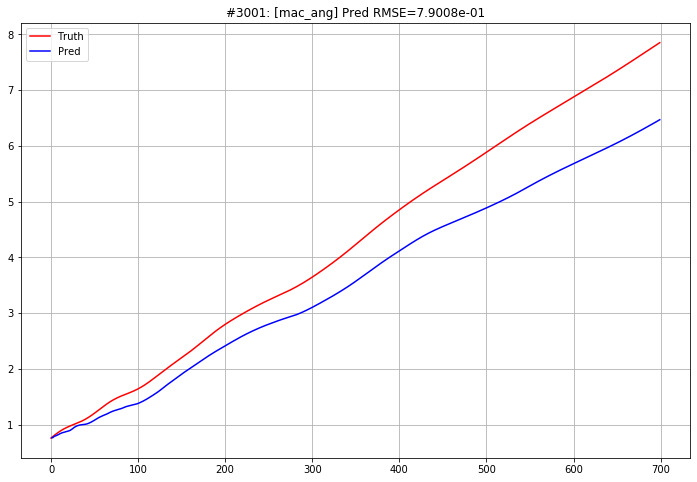

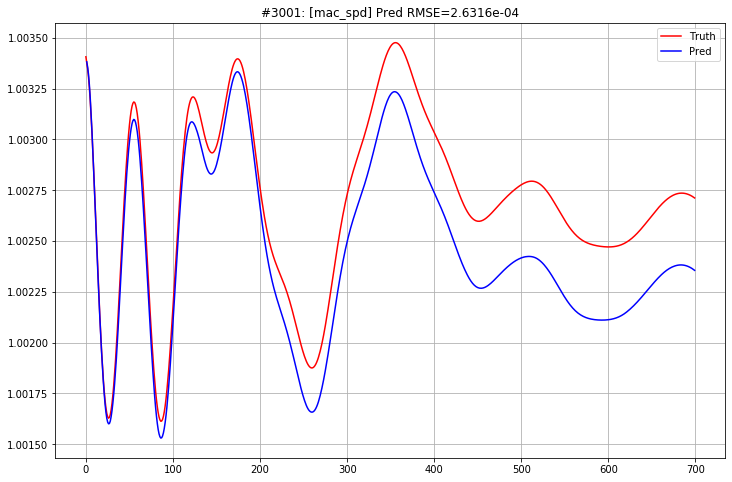

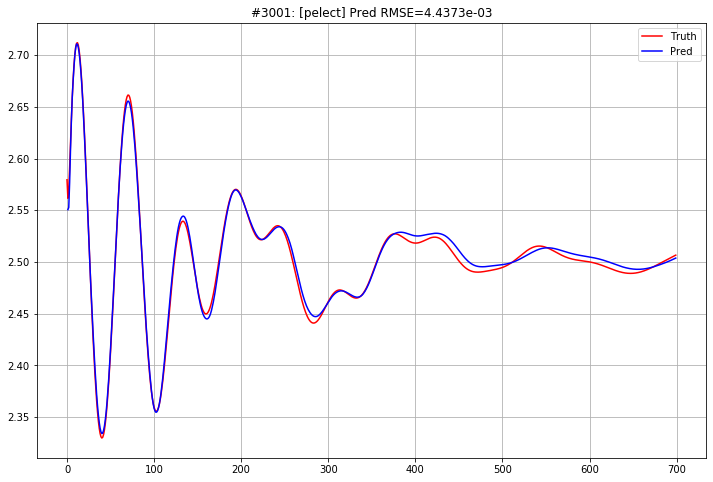

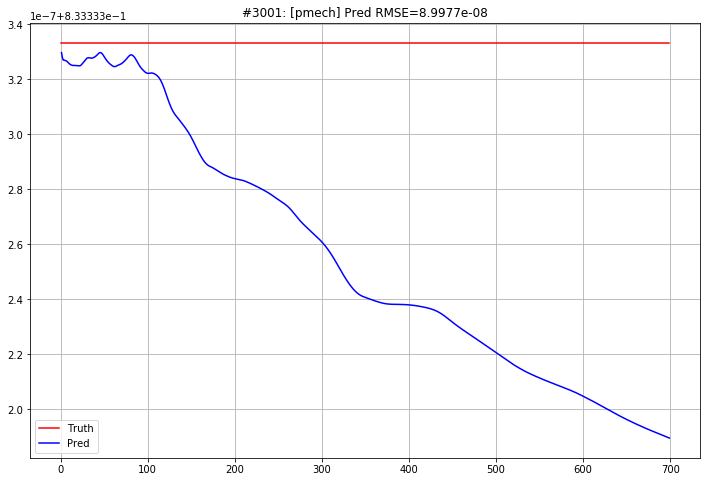

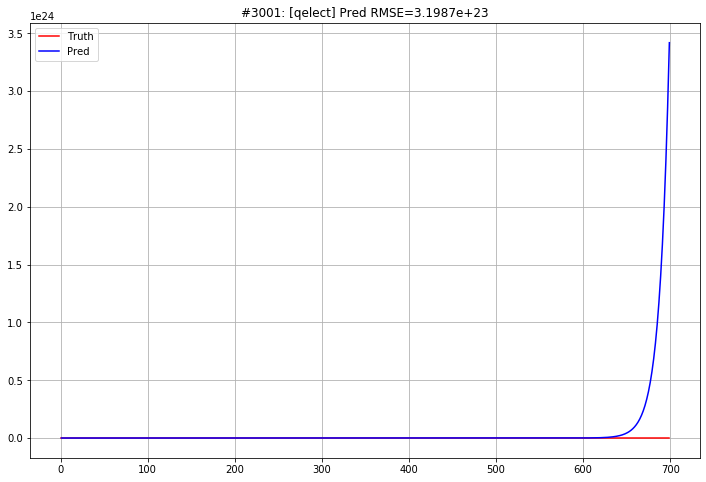

In [7]:
entry = np.floor(np.random.uniform(low=0, high=1500, size=(1, 1))).astype(int).reshape(-1)
# entry=[935-31]
# entry =[1669]
entry = sample_idx[entry]
t_max = 700
if use_cur_sum:
    quantities = [0,1,4,5,6,7,8,9]
    quantities_transform = [0, 1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur_sum', 'A:cur_sum', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
else:
    quantities = [0,1,12,13,14,15,16,17]
    quantities_transform = [0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur1', 'M:cur2', 'M:cur3', 'M:cur4', 'M:cur5', 'A:cur1', 'A:cur2', 'A:cur3', 'A:cur4', 'A:cur5', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
# quantities_replace = [0,1,12,13,15,16,17]
# print('Replacing quantites:')
# for q in quantities_replace:
#     print('    [{:d}]'.format(q),quantites_names[q])
# print('Keeping quantites:')
# for q in quantities:
#     if not (q in quantities_replace):
#         print('    [{:d}]'.format(q),quantites_names[q])
# print()


model_cpu = model.cpu()
model_cpu.eval()
for i in entry:    
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(-1, 1)
    bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)

    if not use_mac_ang:
        mac_ang = np.zeros_like(mac_ang)

    if use_cur_sum:
        cur = np.sum(cur, axis=1).reshape(-1, 1)

    bus_v_ang = np.unwrap(np.angle(bus_v).reshape(-1)).reshape(-1,1)
    cur_ang = np.unwrap(np.angle(cur).reshape(-1)).reshape(-1,1)
    print(np.abs(bus_v).shape, bus_v_ang.shape,np.abs(cur).shape, cur_ang.shape)
    tmp_test_data = np.hstack([np.abs(bus_v), bus_v_ang, np.abs(cur), cur_ang, bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_test_data = np.delete(tmp_test_data, -1, 0)
    
    for q in quantities:
        prediction2 = np.zeros((t_max, 8))
        input_data_raw = tmp_test_data[[0], :]
        for t in range(1, t_max):
            input_data = (input_data_raw - norm_mean) / norm_std
            input_data_torch = torch.from_numpy(input_data).float()
            output_data_torch = model_cpu(input_data_torch)
            if use_cur_sum:
                prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 4, 5, 6, 7, 8, 9]]
                input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3]], prediction2[t, [2, 3, 4, 5, 6, 7]]])
            else:
                prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 12, 13, 14, 15, 16, 17]]
                input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], prediction2[t, [2, 3, 4, 5, 6, 7]]])

            for r in quantities:
                if r != q:
                    input_data_raw[r] = tmp_test_data[t, r]

#             input_data_raw[1] = np.mod(input_data_raw[1]+np.pi, 2*np.pi) - np.pi
            input_data_raw = input_data_raw.reshape(1, -1)
#         print(prediction2.shape)
        
        plt.figure(figsize=(12, 8))
        plt.plot(tmp_test_data[:t_max,q], 'r', label='Truth')
        plt.plot(np.arange(1,t_max), prediction2[1:, quantities_transform[q]], 'b', label='Pred')
#         plt.plot([0, t_max], [tmp_test_data[0,q], tmp_test_data[0,q]], 'g-.', label='Benchmark')
        plt.legend()
        plt.grid(True)
    #     plt.ylim([0.97, 1.03])
        plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}'.format(i, quantites_names[q], np.sqrt(np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1)))) ))
#         plt.title('#{:d}: [{:s}] Pred MSE={:.4e} Benchmark MSE={:.4e}'.format(i, quantites_names[q], np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1))), np.mean(np.square(tmp_test_data[0,q] - tmp_test_data[1:t_max,q].reshape(-1))) ))
    
plt.show()

In [8]:
entry = np.floor(np.random.uniform(low=0, high=1500, size=(1, 1))).astype(int).reshape(-1)
# entry=[3129]
# entry =[4108]
# entry = [5]
entry = sample_idx[entry]
t_max = 700
if use_cur_sum:
    quantities = [0,1,4,5,6,7,8,9]
    quantities_transform = [0, 1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur_sum', 'A:cur_sum', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
else:
    quantities = [0,1,12,13,14,15,16,17]
    quantities_transform = [0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur1', 'M:cur2', 'M:cur3', 'M:cur4', 'M:cur5', 'A:cur1', 'A:cur2', 'A:cur3', 'A:cur4', 'A:cur5', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']


model_cpu = model.cpu()
model_cpu.eval()
for i in entry:    
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(5, -1).T
    bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)

    if not use_mac_ang:
        mac_ang = np.zeros_like(mac_ang)

    if use_cur_sum:
        cur = np.sum(cur, axis=1).reshape(-1, 1)

    tmp_test_data = np.hstack([np.abs(bus_v), np.angle(bus_v), np.abs(cur), np.angle(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_test_data = np.delete(tmp_test_data, -1, 0)
    
    q=6
    for start_t in range(0,600,100):
        prediction2 = np.zeros((t_max, 8))
        input_data_raw = tmp_test_data[[start_t], :]
        for t in range(start_t+1, t_max):
            input_data = (input_data_raw - norm_mean) / norm_std
            input_data_torch = torch.from_numpy(input_data).float()
            output_data_torch = model_cpu(input_data_torch)
            if use_cur_sum:
                prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 4, 5, 6, 7, 8, 9]]
                input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3]], prediction2[t, [2, 3, 4, 5, 6, 7]]])
            else:
                prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 12, 13, 14, 15, 16, 17]]
                input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], prediction2[t, [2, 3, 4, 5, 6, 7]]])

            for r in quantities:
                if r != q:
                    input_data_raw[r] = tmp_test_data[t, r]

#             input_data_raw[1] = np.mod(input_data_raw[1]+np.pi, 2*np.pi) - np.pi
            input_data_raw = input_data_raw.reshape(1, -1)
#         print(prediction2.shape)
        
        plt.figure(1, figsize=(24, 16))
        if (start_t==0):
            plt.plot(tmp_test_data[:t_max,q], 'r', label='Truth')
            plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}'.format(i, quantites_names[q], np.sqrt(np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1)))) ))

        plt.plot(np.arange(start_t+1,t_max), prediction2[start_t+1:, quantities_transform[q]], label='Pred_'+str(start_t))
#         plt.plot([0, t_max], [tmp_test_data[0,q], tmp_test_data[0,q]], 'g-.', label='Benchmark')
        plt.legend()
        plt.grid(True)
    #     plt.ylim([0.97, 1.03])
        #         plt.title('#{:d}: [{:s}] Pred MSE={:.4e} Benchmark MSE={:.4e}'.format(i, quantites_names[q], np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1))), np.mean(np.square(tmp_test_data[0,q] - tmp_test_data[1:t_max,q].reshape(-1))) ))
    
plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 890 and the array at index 2 has size 178

In [ ]:
# entry = np.floor(np.random.uniform(low=0, high=5864, size=(1, 1))).astype(int).reshape(-1)
# entry=[3129]
entry =[4951]
# entry = [sample_idx[1]]
t_max = 700
quantities_replace = []
if use_cur_sum:
    quantities = [0,1,4,5,6,7,8,9]
    quantities_transform = [0, 1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur_sum', 'A:cur_sum', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
#     quantities_replace = [0,1,4,5,7,8,9]
else:
    quantities = [0,1,12,13,14,15,16,17]
    quantities_transform = [0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, 3, 4, 5, 6, 7]
    quantites_names = ['Mag:bus_v', 'Ang:bus_v', 'M:cur1', 'M:cur2', 'M:cur3', 'M:cur4', 'M:cur5', 'A:cur1', 'A:cur2', 'A:cur3', 'A:cur4', 'A:cur5', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect']
    quantities_replace = [0,1,12,13,15,16,17]


print('Replacing quantites:')
for q in quantities_replace:
    print('    [{:d}]'.format(q),quantites_names[q])
print('Keeping quantites:')
for q in quantities:
    if not (q in quantities_replace):
        print('    [{:d}]'.format(q),quantites_names[q])
print()


model_cpu = model.cpu()
model_cpu.eval()
for i in entry:    
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(5, -1).T
    bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)

    if not use_mac_ang:
        mac_ang = np.zeros_like(mac_ang)

    if use_cur_sum:
        cur = np.sum(cur, axis=1).reshape(-1, 1)

    tmp_test_data = np.hstack([np.abs(bus_v), np.angle(bus_v), np.abs(cur), np.angle(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_test_data = np.delete(tmp_test_data, -1, 0)
    

    prediction2 = np.zeros((t_max, 8))
    input_data_raw = tmp_test_data[[0], :]
    for t in range(1, t_max):
        input_data = (input_data_raw - norm_mean) / norm_std
        input_data_torch = torch.from_numpy(input_data).float()
        output_data_torch = model_cpu(input_data_torch)
        if use_cur_sum:
            prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 4, 5, 6, 7, 8, 9]]
            input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3]], prediction2[t, [2, 3, 4, 5, 6, 7]]])
        else:
            prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 12, 13, 14, 15, 16, 17]]
            input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], prediction2[t, [2, 3, 4, 5, 6, 7]]])

        input_data_raw[quantities_replace] = tmp_test_data[t, quantities_replace]

#         input_data_raw[1] = np.mod(input_data_raw[1]+np.pi, 2*np.pi) - np.pi
        input_data_raw = input_data_raw.reshape(1, -1)
#         print(prediction2.shape)

    for q in quantities:
        if q==14 or not (q in quantities_replace):
            plt.figure(figsize=(12, 8))
            plt.plot(tmp_test_data[:t_max,q], 'r', label='Truth')
            plt.plot(np.arange(1,t_max), prediction2[1:, quantities_transform[q]], 'b', label='Pred')
            plt.legend()
            plt.grid(True)
        #     plt.ylim([0.97, 1.03])
            plt.title('#{:d}: [{:s}] Pred RMSE={:.4e}'.format(i, quantites_names[q], np.sqrt(np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1)))) ))
    
plt.show()

# for i in entry:
#     print('#{:d} sample is '.format(i), end='')
#     if entry[0] in sample_idx[:n_sample]:
#         print('in training set.')
#     else:
#         print('not in training set.')
    
#     bus_v = data['bus_v'][0][i].reshape(-1, 1)
#     cur = data['cur'][0][i].reshape(5, -1).T
#     bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
#     mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
#     mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
#     pelect = data['pelect'][0][i].reshape(-1, 1)
#     pmech = data['pmech'][0][i].reshape(-1, 1)
#     qelect = data['qelect'][0][i].reshape(-1, 1)
    
# #     mac_ang = np.zeros_like(mac_ang)

#     tmp_test_data = np.hstack([np.abs(bus_v), np.angle(bus_v), np.abs(cur), np.angle(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
# #     tmp_test_data = (tmp_test_data - norm_mean) / norm_std

# #     tmp_test_label = np.delete(tmp_test_data, 0, 0)
#     tmp_test_data = np.delete(tmp_test_data, -1, 0)

# #     tmp_test_data[:,13] = 0

# #     input_data_torch = torch.from_numpy(tmp_test_data).float()
# #     prediction = model_cpu(input_data_torch).data.numpy()
# #     prediction = prediction * label_std + label_mean + tmp_test_data * norm_std + norm_mean
# #     print(prediction.shape)
# #     mac_spd = mac_spd[1:]

# #     plt.figure(figsize = (12,8))
# #     plt.plot(mac_spd,'r')
# #     plt.plot(prediction[:,14], 'b')
# #     plt.legend(['Truth','Pred'])
# #     plt.grid(True)
# #     plt.title('#%d: MSE=%.4e benchmark=%.4e'%(i, np.mean(np.square(prediction[:,14] - mac_spd)), np.mean(np.square(tmp_test_data[:,14]*norm_std[14]+norm_mean[14] - mac_spd))))

#     prediction2 = np.zeros((t_max, 8))
#     input_data_raw = tmp_test_data[[0], :]
#     print(input_data_raw)
#     for t in range(1, t_max):
# #         input_data[0,3] = 0
#         input_data = (input_data_raw - norm_mean) / norm_std
#         input_data_torch = torch.from_numpy(input_data).float()
#         output_data_torch = model_cpu(input_data_torch)
#         prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + input_data_raw[:, [0, 1, 12, 13, 14, 15, 16, 17]]
#         input_data_raw = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], prediction2[t, [2, 3, 4, 5, 6, 7]]])

        

#         input_data_raw[1] = np.mod(input_data_raw[1]+np.pi, 2*np.pi) - np.pi
#         input_data_raw = input_data_raw.reshape(1, -1)
#     print(prediction2.shape)

#     for q in quantities:
#             plt.figure(figsize=(12, 8))
#             plt.plot(tmp_test_data[:t_max,q], 'r', label='Truth')
#             plt.plot(np.arange(1,t_max), prediction2[1:, quantities_transform[q]], 'b', label='Pred')
#             plt.plot([0, t_max], [tmp_test_data[0,q], tmp_test_data[0,q]], 'g-.', label='Benchmark')
#             plt.legend()
#             plt.grid(True)
#         #     plt.ylim([0.97, 1.03])
#             plt.title('#{:d}: [{:s}] Pred MSE={:.4e} Benchmark MSE={:.4e}'.format(i, quantites_names[q], np.mean(np.square(prediction2[1:, quantities_transform[q]] - tmp_test_data[1:t_max,q].reshape(-1))), np.mean(np.square(tmp_test_data[0,q] - tmp_test_data[1:t_max,q].reshape(-1))) ))
#             print(tmp_test_data[0,q])
    
# plt.show()